# Imports

We use the following libraries to fetch and parse html pages, and to interact with the Foursquare API.

In [1]:
import requests
import requests_cache

# Request_cache caches all calls to wikipedia and foursquare so we only have to do it once.
requests_cache.install_cache('requests_cache')

import json

We use regular expressions, e.g. to extract population count and city coordinates from scraped webpages

In [2]:
import re

We use Pandas for building the dataframe.

In [3]:
import pandas as pd

ast to parse a string to a dict

In [4]:
import ast

We use folium for creating maps

In [5]:
import folium
from folium import plugins

We use GeoPandas for working with coordinates

In [6]:
from shapely.geometry import shape, Point
from geopandas import GeoSeries

Matplotlib for graphs and color related functionality

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

We use NumPy and Scikit-learn for clustering

In [8]:
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances

# The Eindhoven neighbourhood datasets

## Obtaining the dataset

Found some datasets on Eindhoven neighbourhoods on https://data.eindhoven.nl/explore/dataset/buurten/export/

In [9]:
# read csv file|
df_ehv = pd.read_csv('buurten.csv', sep=';')

## Cleaning up the neighbourhood dataset

In [10]:
# split latitude and longitude into separate columns
df_ehv[['Latitude', 'Longitude']] = df_ehv['geo_point_2d'].str.split(',', expand=True)
df_ehv[['Latitude', 'Longitude']] = df_ehv[['Latitude', 'Longitude']].apply(lambda x: x.str.strip()).astype(float)

# store the geometric shape
df_ehv['Geo_shape'] = df_ehv['geo_shape'].apply(lambda x: dict(ast.literal_eval(x)))

# drop uninteresting columns
df_ehv.drop(['SHAPE.AREA', 'SHAPE.LEN', 'Objectid ', 'geo_shape', 'geo_point_2d'], axis=1, inplace=True)

# rename change column names
df_ehv.columns = ['Buurtcode', 'Buurtnaam', 'Wijkcode', 'Wijknaam', 'Stadsdeelcode', 'Stadsdeelnaam', 'Latitude', 'Longitude', 'Geo_shape']

df_ehv.head()

,Buurtcode,Buurtnaam,Wijkcode,Wijknaam,Stadsdeelcode,Stadsdeelnaam,Latitude,Longitude,Geo_shape
0,240,Riel,23,Putten,2,Stratum,51.416701,5.521553,"{'type': 'Polygon', 'coordinates': [[[5.515769..."
1,632,Meerbos,63,Meerhoven,6,Strijp,51.450561,5.416852,"{'type': 'Polygon', 'coordinates': [[[5.410912..."
2,731,Genderbeemd,73,Gestelse Ontginning,7,Gestel,51.422574,5.438449,"{'type': 'Polygon', 'coordinates': [[[5.427909..."
3,231,Poeijers,23,Putten,2,Stratum,51.431234,5.518226,"{'type': 'Polygon', 'coordinates': [[[5.518753..."
4,512,Prinsejagt,51,Ontginning,5,Woensel-Noord,51.468302,5.458431,"{'type': 'Polygon', 'coordinates': [[[5.467129..."


## Exploring the dataset

We can see from this set how many neighbourhoods (buurten), residential areas (wijken) and boroughs (stadsdeel) the city of Eindhoven has:

In [11]:
print("Eindhoven has {} neighbourhoods (buurt) in {} residential areas (wijk), spread over {} boroughs (stadsdeel)".format(df_ehv.shape[0], len(df_ehv.groupby('Wijkcode')), len(df_ehv.groupby('Stadsdeelcode'))))

Eindhoven has 116 neighbourhoods (buurt) in 20 residential areas (wijk), spread over 7 boroughs (stadsdeel)


## Putting Eindhoven on the map

To give an initial indication of how the various neighbourhoods look, we plot the shapes from a GeoJSON file containing exactly the same locations as in the table.
Later, we will add more to this map.

In [12]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12)

fs = plugins.Fullscreen()
ehv_map.add_child(fs)

folium.GeoJson('buurten.geojson.json').add_to(ehv_map)

ehv_map

# Getting key figures

## Obtaining the dataset

Found some datasets on Eindhoven neighbourhoods key figures on [https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84286NED/table?ts=1546775064672]

In [13]:
# read csv file|
df_kern = pd.read_csv('kerncijfers.csv', ";")
df_kern.head()

,Wijken en buurten,Gemeentenaam,Soort regio,Codering,Indelingswijziging wijken en buurten,Inwoners,Inwoners 15 tot 25 jaar,Inwoners Westers totaal,Inwoners Nederlandse Antillen en Aruba,Eenpersoonshuishoudens,Bevolkingsdichtheid,Woningvoorraad,Percentage meergezinswoning,Personenauto's; brandstof benzine,Motorfietsen,Oppervlakte,Mate van stedelijkheid,Omgevingsadressendichtheid
0,Eindhoven,Eindhoven,Gemeente,GM0772,NaN,229126,31821,33209,2772,57152,2614.0,109468,38.0,82010,6820,8766,1.0,2605.0
1,Wijk 11 Stadsdeel Centrum,Eindhoven,Wijk,WK077211,1.0,8975,2165,2220,85,4660,3421.0,5827,93.0,2200,265,262,1.0,3938.0
2,Binnenstad,Eindhoven,Buurt,BU07721111,1.0,3595,865,765,45,1930,5491.0,2163,91.0,910,85,66,1.0,3862.0
3,Bergen,Eindhoven,Buurt,BU07721112,1.0,2560,505,570,15,1215,7452.0,1595,85.0,760,80,34,1.0,4173.0
4,Witte Dame,Eindhoven,Buurt,BU07721113,1.0,1860,310,535,15,735,10132.0,1468,100.0,460,95,18,1.0,4412.0


## Cleaning up the neighbourhood dataset

In [14]:
# We only want neighbourhoods, not aggregated results
df_kern = df_kern[df_kern["Soort regio"] == "Buurt"]

# Pick some interesting columns
df_kern = df_kern[["Wijken en buurten", "Bevolkingsdichtheid", "Mate van stedelijkheid", "Omgevingsadressendichtheid"]]
df_kern.columns = ["Buurtnaam", "Dichtheid", "Stedelijkheid", "Adresdichtheid"]
df_kern[["Dichtheid", "Stedelijkheid", "Adresdichtheid"]].astype(float)

df_kern.head()

,Buurtnaam,Dichtheid,Stedelijkheid,Adresdichtheid
2,Binnenstad,5491.0,1.0,3862.0
3,Bergen,7452.0,1.0,4173.0
4,Witte Dame,10132.0,1.0,4412.0
5,Fellenoord,751.0,1.0,3958.0
6,TU-terrein,648.0,2.0,2051.0


Now let's see if we have any NaN's left to deal with.

In [15]:
df_kern[df_kern.isnull().any(1)]

,Buurtnaam,Dichtheid,Stedelijkheid,Adresdichtheid
23,Poeijers,NaN,2.0,1761.0
31,Leenderheide,NaN,NaN,NaN
106,Flight Forum,NaN,5.0,229.0
107,Eindhoven Airport,NaN,5.0,70.0
120,Beemden,NaN,4.0,663.0


These are all industrial aread with no residents, except for Leenderheide which is nature reserve. Let's replace the NaNs with zeroes.

In [16]:
df_kern = df_kern.fillna(0)

## Linking up to the previous data set

In [17]:
df_ehv = pd.merge(df_ehv, df_kern, on="Buurtnaam", validate="1:1")
df_ehv.head()

,Buurtcode,Buurtnaam,Wijkcode,Wijknaam,Stadsdeelcode,Stadsdeelnaam,Latitude,Longitude,Geo_shape,Dichtheid,Stedelijkheid,Adresdichtheid
0,240,Riel,23,Putten,2,Stratum,51.416701,5.521553,"{'type': 'Polygon', 'coordinates': [[[5.515769...",99.0,4.0,737.0
1,632,Meerbos,63,Meerhoven,6,Strijp,51.450561,5.416852,"{'type': 'Polygon', 'coordinates': [[[5.410912...",38.0,3.0,1078.0
2,731,Genderbeemd,73,Gestelse Ontginning,7,Gestel,51.422574,5.438449,"{'type': 'Polygon', 'coordinates': [[[5.427909...",3673.0,2.0,1799.0
3,231,Poeijers,23,Putten,2,Stratum,51.431234,5.518226,"{'type': 'Polygon', 'coordinates': [[[5.518753...",0.0,2.0,1761.0
4,512,Prinsejagt,51,Ontginning,5,Woensel-Noord,51.468302,5.458431,"{'type': 'Polygon', 'coordinates': [[[5.467129...",4882.0,2.0,2374.0


## Choropleth map of Eindhoven

Let's make a choropleth map of the neighbourhoods based on population density. 
The result clearly show some neighbourhoods with no people living in it. These are two industrial areas, an airport and a park

In [18]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12)

fs = plugins.Fullscreen()
ehv_map.add_child(fs)

folium.GeoJson('buurten.geojson.json').add_to(ehv_map)

folium.Choropleth(
    geo_data='buurten.geojson.json',
    name='Population Density',
    data=df_ehv,
    columns=['Buurtcode', 'Dichtheid'],
    key_on='feature.properties.buurtcode',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density'
).add_to(ehv_map)

ehv_map

# Getting venue information from Foursquare

In this section we will ask Foursquare for the Top Picks venues in neighbourhood in the city of Eindhoven

## Setting up the connection

The following information is needed to connect with Foursquare API

In [19]:
CLIENT_ID = 'YPBVFDUZOP1M24BKCWGXIYZ3RFACOE3V35WSFY4DSCMRU44L' # your Foursquare ID
CLIENT_SECRET = 'VYHYTBSRIZBPYAOCP5ZEFV3YM4C40YEQCQWCUO4NC1JTPNJM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Generalizing Categories

The Foursquare API gives back way too many categories to be of any practical use. We would like to generalize the categories by 1 step in Foursquare's category hierarchy.

The following code parses the categories list into something we can use during scraping. 

In [20]:
url = "https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION )
response = requests.get(url)
cats = {}

def crawl(catlist=response.json()['response'], parents=[]):
    for c in catlist['categories']:
        cats[c['name']] = parents + [c['name']]
        crawl(c, parents + [c['name']])
        
crawl()

## Scraper function

We will ask Foursquare for venues in every neighbourhoods, then store its name, location and main category.

The following function takes series of Cities and their latituted and longitudes. It will then output a dataframe containing all these venues. 

We try to find as many venues as possible within the smallest circle that surrounds the neighbourhood. We find that circle by taking a maximum distance between the center point of the neighbourhood and the vertices of the polygon describing it. Unfortunately all the coordinates are in WGS84 (epsg:4326) format. We need to convert to rijksdriehoekscoördinaten (epsg:28992), where coordinates correspond to meters (at least in the Netherlands).

In [21]:
# convert coordinates from epsg:4326 to epsg:28992
def convertgeopoint(point):
    geopoint = point
    geopoint.crs = {'init': 'epsg:4326'}
    return geopoint.to_crs(epsg=28992)

# find the maximum distance between the center of a neighbourhood and the edges as defined in the shape polygon
def maxdistance(lat, lon, polystring):
    # convert point to  28992 coordinates
    geopoint = convertgeopoint(GeoSeries(Point(lon,lat)))
    
    # convert shape to list of points
    l = list(map(lambda x: convertgeopoint(GeoSeries(Point(x[0],x[1]))), dict(polystring)['coordinates'][0]))
    
    # find distances
    l = list(map(lambda x: geopoint.distance(x).values[0], l))
    
    return max(l)

We use this function in the actual scraper function where we will set a radius using the above.

In [22]:
LIMIT=50

def getRecommendedVenues(neighbourhoods, nbcodes, latitudes, longitudes, polygons):
    
    venues_list=[]
    for nb, code, lat, lon, poly in zip(neighbourhoods, nbcodes, latitudes, longitudes, polygons):
         
        # compute radius for neighbourhood    
        radius = maxdistance(lat, lon, poly)
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&intent=browse&v={}&ll={},{}&limit={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lon,
            LIMIT,                
            radius)

        # make the GET request
        response = requests.get(url)
        if response.status_code == requests.codes.ok:
            results = requests.get(url).json()["response"]['venues']
            if len(results)==0:
                continue
        else:
            print ("status was:" + str(response.status_code))
            print ("could not scrape " + url)
            print (response)
            break

        polygon = shape(poly)
        for v in results:
            if len(v['categories']) != 0:
                point = Point(v['location']['lng'],v['location']['lat'])
                if polygon.contains(point):
                    venues_list.append([(
                        code,
                        v['name'], 
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],  
                        v['categories'][0]['name'],
                        cats[v['categories'][0]['name']][0]
                        )])
                    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Buurtcode',
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category Generalized']
    
    return(nearby_venues)

## Scraping from foursquare

Now we can run it on all the cities from our cities dataframe and store the found venues in a new dataframe.
This can take a while when running for the first time, and also fail a few times with a 504 error. 

But every request will be cached, which makes subsequent calls incredibly fast.

In [23]:
df_venues = getRecommendedVenues(df_ehv['Buurtnaam'], df_ehv['Buurtcode'], df_ehv['Latitude'], df_ehv['Longitude'], df_ehv['Geo_shape'])
print ("Found {} venues for {} different neighbourhoods".format(df_venues.shape[0], len(df_venues.groupby('Buurtcode'))))

df_venues_unique = df_venues.drop(['Buurtcode'], axis=1).drop_duplicates()
print ("Found {} unique venues, consisting of {} unique categories and {} generalized categories.".format(df_venues_unique.shape[0],len(df_venues.groupby('Venue Category')),len(df_venues.groupby('Venue Category Generalized'))))

df_venues.head()

Found 3185 venues for 116 different neighbourhoods
Found 3185 unique venues, consisting of 388 unique categories and 10 generalized categories.


,Buurtcode,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Venue Category Generalized
0,240,Random Veld Eindhoven,57190012498ebfa7c0bc536b,51.415874,5.524489,Other Great Outdoors,Outdoors & Recreation
1,240,wirowok st wirostraat eindhoven,4e1c6999a80980ebf5a18737,51.416636,5.518441,Asian Restaurant,Food
2,240,Fietsknooppunt 27 (Noord Brabant),4eccbada6c25f61c322446eb,51.418031,5.518135,Bike Trail,Outdoors & Recreation
3,240,Stal De Groof,4db971516e818f67a9be8786,51.419093,5.523564,Farm,Outdoors & Recreation
4,240,Riel,4b5afa01f964a52013dd28e3,51.424553,5.522202,Scenic Lookout,Outdoors & Recreation


## Putting venues on the map

Putting all venues on a map is a stretch for Jupyter, so it may not actually display.  
Fortunately we can export the map as HTML and open it separately.

In [24]:
# create map of the world using latitude and longitude values
ehv_venues_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_venues_map.add_child(fs)


folium.GeoJson('buurten.geojson.json').add_to(ehv_venues_map)

# add markers to map for every venue
for lat, lng, venue, cat in zip(df_venues_unique['Venue Latitude'], df_venues_unique['Venue Longitude'], df_venues_unique['Venue'], df_venues_unique['Venue Category']):
    label = '{}: {}'.format(venue, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(ehv_venues_map)  
    
# save the map to interactive html, then display
ehv_venues_map.save('ehv_venues_map.html')

[Link to generated map](ehv_venues_map.html)

# Clustering neighbourhoods

## Counting venue categories

Just as in the lectures, we want to find out what the types of venues are for each neighbourhood.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every neighbourhood.
This automatically takes care of having different amounts of venues for different neighbourhoods.

In [25]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category Generalized']], prefix="", prefix_sep="")

# add other columns back to the dataframe
df_venues_onehot['Buurtcode'] = df_venues['Buurtcode']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

,Buurtcode,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,240,0,0,0,0,0,1,0,0,0,0
1,240,0,0,0,1,0,0,0,0,0,0
2,240,0,0,0,0,0,1,0,0,0,0
3,240,0,0,0,0,0,1,0,0,0,0
4,240,0,0,0,0,0,1,0,0,0,0


## Most common venue categories per city

In [26]:
df_venues_grouped = df_venues_onehot.groupby(['Buurtcode']).sum().reset_index()

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['Buurtcode']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['Buurtcode'] = df_venues_grouped['Buurtcode']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [29]:
df_common_venues.head()

,Buurtcode,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5
0,111,Shop & Service,Food,Professional & Other Places,Nightlife Spot,Travel & Transport
1,112,Shop & Service,Professional & Other Places,Food,Nightlife Spot,Residence
2,113,Professional & Other Places,Outdoors & Recreation,Shop & Service,Food,Travel & Transport
3,114,Travel & Transport,Professional & Other Places,Shop & Service,Food,Outdoors & Recreation
4,115,College & University,Professional & Other Places,Shop & Service,Nightlife Spot,Travel & Transport


## Finding similar neighbourhoods

For clustering, we use the averages for every category as found in section 3, but drop the buurtcode attributes.  
Then, we merge back Density, urbanisation and housing density fields.

In [30]:
# sum the venues types found for each neighbourhood
df_clustering = df_venues_onehot.groupby(['Buurtcode']).sum().reset_index()

# normalize over all columns except the 'Buurtcode' column.
collist = df_clustering.columns.tolist()
collist.remove('Buurtcode')
df_clustering[collist] = df_clustering[collist].div(df_clustering.sum(axis=1), axis=0)

# merge back in additional columns
df_clustering = pd.merge(df_clustering, df_ehv[["Buurtcode", "Dichtheid", "Stedelijkheid", "Adresdichtheid"]], on="Buurtcode")
df_clustering.head()

# scale all the features
for i in df_clustering.columns[1:]:
    df_clustering[i] = preprocessing.minmax_scale(df_clustering[i].astype('float64'))

df_clustering.head()

,Buurtcode,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Dichtheid,Stedelijkheid,Adresdichtheid
0,111,0.478261,0.000000,0.0,1.000000,0.993789,0.231588,0.321674,0.000000,1.000000,0.069654,0.460345,0.2,0.875340
1,112,0.481250,0.000000,0.0,0.914773,1.000000,0.000000,0.809211,0.768750,0.774038,0.035045,0.624748,0.2,0.945830
2,113,1.000000,0.026461,0.0,0.570248,0.000000,0.968460,0.756664,0.399351,0.281469,0.182050,0.849430,0.2,1.000000
3,114,0.490446,0.000000,0.0,0.279676,0.339703,0.237489,0.329869,0.000000,0.118324,1.000000,0.062961,0.2,0.897099
4,115,0.000000,1.000000,0.0,0.000000,0.654397,0.000000,0.317727,0.000000,0.075979,0.000000,0.054326,0.4,0.464869


### Finding optimal value for $k$

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.038181400093122105, which occurs at k=2


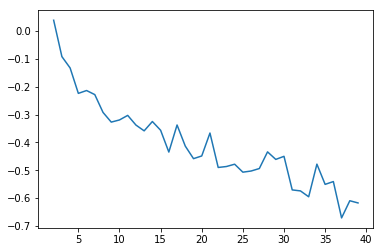

In [31]:
START = 2
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering, but drop the first column (buurtcode)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_clustering[df_clustering.columns[1:]])
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

### Clustering

We use Scikit-learn for kmeans clustering, with $k=\mathrm{kclusters}$ clusters.

In [32]:
kclusters = 17
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering[df_clustering.columns[1:]])

We add these labels to the cities dataframe, as well as the most common venues found in the previous section.

We save the result as a new dataframe

In [33]:
df_common_venues['Cluster label'] = kmeans.labels_

df_ehv_clusters = pd.merge( df_ehv, df_common_venues, how='left',
        on=['Buurtcode'])
df_ehv_clusters.head()

,Buurtcode,Buurtnaam,Wijkcode,Wijknaam,Stadsdeelcode,Stadsdeelnaam,Latitude,Longitude,Geo_shape,Dichtheid,Stedelijkheid,Adresdichtheid,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label
0,240,Riel,23,Putten,2,Stratum,51.416701,5.521553,"{'type': 'Polygon', 'coordinates': [[[5.515769...",99.0,4.0,737.0,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Residence,0
1,632,Meerbos,63,Meerhoven,6,Strijp,51.450561,5.416852,"{'type': 'Polygon', 'coordinates': [[[5.410912...",38.0,3.0,1078.0,Travel & Transport,Outdoors & Recreation,Food,Shop & Service,Residence,11
2,731,Genderbeemd,73,Gestelse Ontginning,7,Gestel,51.422574,5.438449,"{'type': 'Polygon', 'coordinates': [[[5.427909...",3673.0,2.0,1799.0,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Shop & Service,Residence,5
3,231,Poeijers,23,Putten,2,Stratum,51.431234,5.518226,"{'type': 'Polygon', 'coordinates': [[[5.518753...",0.0,2.0,1761.0,Professional & Other Places,Shop & Service,Food,College & University,Travel & Transport,3
4,512,Prinsejagt,51,Ontginning,5,Woensel-Noord,51.468302,5.458431,"{'type': 'Polygon', 'coordinates': [[[5.467129...",4882.0,2.0,2374.0,Professional & Other Places,Shop & Service,Outdoors & Recreation,Residence,Nightlife Spot,2


## Putting the clusters on a map

Create a color table for these clusters

In [34]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Now actually put the cities on the map with a color depending on their cluster.

In [35]:
# create map of the world using latitude and longitude values
ehv_clusters_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_clusters_map.add_child(fs)


# add markers to map for every neighbourhood
for name, cluster, shape in zip(df_ehv_clusters['Buurtnaam'], df_ehv_clusters['Cluster label'], df_ehv_clusters['Geo_shape']):
    geojson = folium.Choropleth(
        geo_data=shape,
        radius=7,
        fill_color=rainbow[cluster-1]
    )
    label = folium.Popup(name)
    label.add_to(geojson)
    geojson.add_to(ehv_clusters_map)  

# save the map to interactive html, then display
ehv_clusters_map.save('ehv_clusters.html')
ehv_clusters_map

## Examining the clusters

In [36]:
clusters = pd.DataFrame(df_ehv_clusters.groupby('Cluster label', as_index=False).apply(lambda x: ", ".join(x['Buurtnaam'].tolist())), columns=['Similar'])
clusters['Count'] = df_ehv_clusters.groupby('Cluster label')['Buurtcode'].count()
print("Cluster | Count | Neighbourhoods")
print("--------|-------|---------------")
for x,y,z in zip(clusters.index,clusters['Count'],clusters['Similar']):
    print("{} | {} | {}".format(x,y,z))

Cluster | Count | Neighbourhoods
--------|-------|---------------
0 | 14 | Riel, BeA2, Urkhoven, Bokt, Bosrijk, Karpen, Wielewaal, Herdgang, Park Forum, Eindhoven Airport, Koudenhoven, Kerkdorp Acht, Eckartdal, Castiliëlaan
1 | 8 | Woensel-West, Eliasterrein, Vonderkwartier, Joriskwartier, Kronehoef, Gerardusplein, Generalenbuurt, Limbeek-Noord, Rochusbuurt
2 | 11 | Prinsejagt, Jagershoef, Tempel, Doornakkers-West, Oude Gracht-West, Gijzenrooi, Woenselse Heide, Eckart, Doornakkers-Oost, Rapenland, Muschberg, Geestenberg
3 | 10 | Poeijers, Mispelhoef, Hurk, Kapelbeemd, Esp, Beemden, Flight Forum, Hondsheuvels, Vredeoord, Eikenburg
4 | 1 | Binnenstad
5 | 23 | Genderbeemd, Lievendaal, 't Hofke, Hanevoet, Bennekel-West, Gagelbosch, Achtse Barrier-Hoeven, Rapelenburg, Elzent-Zuid, Grasrijk, Achtse Barrier-Spaaihoef, Achtse Barrier-Gunterslaer, Het Ven, Heesterakker, Drents Dorp, Oude Gracht-Oost, Bennekel-Oost, Vaartbroek, Blixembosch-Oost, Lakerlopen, Zandrijk, Engelsbergen, Genneperzijde,

# Build a decision tree

In this section, we want to build a decision tree that shows us which cluster we should go to under which conditions.

## Compile a dataset

To create a decision tree, we want a dataset containing per neighbourhood the mean version of the one-hot encoding of venues, as wel as the cluster labels

We ask the following question: Is there a recommended venue of this type in vicinity of this neighbourhood?

That gives us a decision tree of the following style: We can decide which type of neighbourhood we want to move to depending on which venues are there.

In [37]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category Generalized']], prefix="", prefix_sep="")

# add buurtcode column back to the dataframe
df_venues_onehot['Buurtcode'] = df_venues['Buurtcode']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

# training samples: Is there a venue of this type in this city?
X = df_venues_onehot.groupby(['Buurtcode']).max().reset_index().drop(['Buurtcode'],1).astype(int)

# class labels
Y = df_ehv_clusters['Cluster label']

## Creating the decision tree

In [38]:
clf = tree.DecisionTreeClassifier(criterion='entropy' )
clf = clf.fit(X, Y)

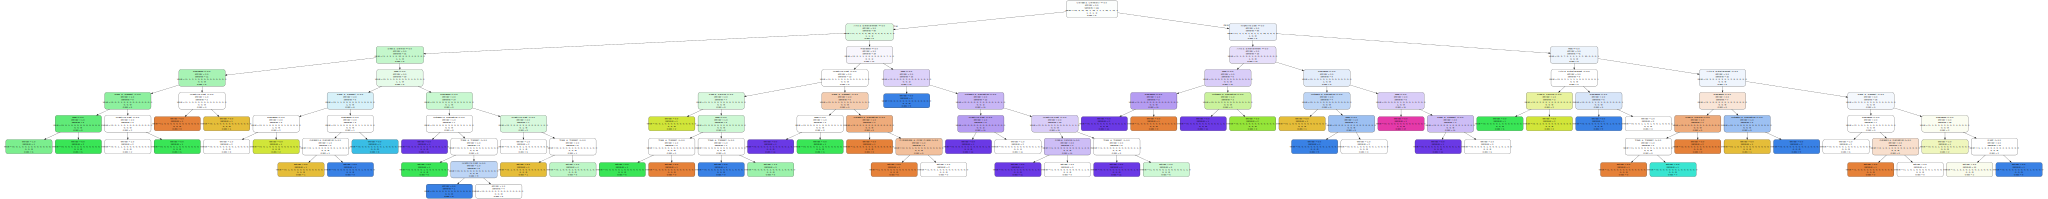

In [39]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, 
    feature_names=X.columns.values,
    class_names=list(map(str,range(max(Y)+1))),
    filled=True, rounded=True, precision=0,
    out_file=None) 
graph = graphviz.Source(dot_data, format='svg')
graph.render(filename='figs/decision')
graph

In [40]:
df_topfeatures = pd.DataFrame({'Feature': X.columns.values, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False).head().reset_index()
df_topfeatures

,index,Feature,Importance
0,7,Residence,0.193256
1,3,Food,0.172425
2,0,Arts & Entertainment,0.156455
3,4,Nightlife Spot,0.140008
4,9,Travel & Transport,0.103682


# Closeness to Prinsejagt

As I live in Prinsejagt, I want to know which neighbourhood is most similar.
We will reuse the clustering dataframe and compute the distance to Prinsejagt for every neighbourhood.

## In a table

In [41]:
df_ehv_clusters[df_ehv_clusters.Buurtnaam == 'Prinsejagt']

,Buurtcode,Buurtnaam,Wijkcode,Wijknaam,Stadsdeelcode,Stadsdeelnaam,Latitude,Longitude,Geo_shape,Dichtheid,Stedelijkheid,Adresdichtheid,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label
4,512,Prinsejagt,51,Ontginning,5,Woensel-Noord,51.468302,5.458431,"{'type': 'Polygon', 'coordinates': [[[5.467129...",4882.0,2.0,2374.0,Professional & Other Places,Shop & Service,Outdoors & Recreation,Residence,Nightlife Spot,2


In [42]:
#Prinsejagt is at row 4
prinsejagt = df_clustering.loc[4,:].drop('Buurtcode')
df_ehv_clusters['d_prinsejagt'] = df_clustering[df_clustering.columns[1:]].apply(lambda x: sum((prinsejagt - x)**2)**.5, axis=1)
top5 = df_ehv_clusters.sort_values(by='d_prinsejagt').head(5)
top5

,Buurtcode,Buurtnaam,Wijkcode,Wijknaam,Stadsdeelcode,Stadsdeelnaam,Latitude,Longitude,Geo_shape,Dichtheid,Stedelijkheid,Adresdichtheid,Common Venue 1,Common Venue 2,Common Venue 3,Common Venue 4,Common Venue 5,Cluster label,d_prinsejagt
4,512,Prinsejagt,51,Ontginning,5,Woensel-Noord,51.468302,5.458431,"{'type': 'Polygon', 'coordinates': [[[5.467129...",4882.0,2.0,2374.0,Professional & Other Places,Shop & Service,Outdoors & Recreation,Residence,Nightlife Spot,2,0.000000
55,222,Gerardusplein,22,Kortonjo,2,Stratum,51.419949,5.488352,"{'type': 'Polygon', 'coordinates': [[[5.493298...",7353.0,1.0,2776.0,Professional & Other Places,Outdoors & Recreation,Shop & Service,Food,Nightlife Spot,1,0.974095
113,333,"Muschberg, Geestenberg",33,Oud-Tongelre,3,Tongelre,51.444405,5.521267,"{'type': 'Polygon', 'coordinates': [[[5.512927...",5204.0,2.0,1801.0,Professional & Other Places,Shop & Service,Outdoors & Recreation,Residence,Nightlife Spot,2,1.132722
53,232,Burghplan,23,Putten,2,Stratum,51.427787,5.506934,"{'type': 'Polygon', 'coordinates': [[[5.513998...",6100.0,2.0,2181.0,Professional & Other Places,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,7,1.146957
89,337,Koudenhoven,33,Oud-Tongelre,3,Tongelre,51.458656,5.514990,"{'type': 'Polygon', 'coordinates': [[[5.498301...",289.0,4.0,669.0,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Nightlife Spot,0,1.165075


## On the map

In [43]:
# create map of the world using latitude and longitude values
prinsejagt_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12)

fs = plugins.Fullscreen()
prinsejagt_map.add_child(fs)

folium.Choropleth(
    geo_data='buurten.geojson.json',
    name='Distance to Prinsejagt',
    data=df_ehv_clusters,
    columns=['Buurtcode', 'd_prinsejagt'],
    key_on='feature.properties.buurtcode',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Distance to Prinsejagt'
).add_to(prinsejagt_map)

prinsejagt_map

# Making a choice

Finally, we look at how many of the most distinguishing features each of these nominated areas has.

In [44]:
features = df_topfeatures['Feature'].values.tolist()
pd.merge(top5, df_venues_onehot.groupby('Buurtcode').sum()[features], on='Buurtcode')[ ['Buurtnaam'] + df_topfeatures['Feature'].values.tolist()]

,Buurtnaam,Residence,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport
0,Prinsejagt,3,0,1,3,1
1,Gerardusplein,2,6,2,4,0
2,"Muschberg, Geestenberg",2,2,1,2,1
3,Burghplan,1,2,1,4,4
4,Koudenhoven,0,1,0,1,1


In [50]:
df_ehv_clusters[df_ehv_clusters.Buurtnaam == 'Burghplan'].squeeze()

Buurtcode                                                       232
Buurtnaam                                                 Burghplan
Wijkcode                                                         23
Wijknaam                                                     Putten
Stadsdeelcode                                                     2
Stadsdeelnaam                                               Stratum
Latitude                                                    51.4278
Longitude                                                   5.50693
Geo_shape         {'type': 'Polygon', 'coordinates': [[[5.513998...
Dichtheid                                                      6100
Stedelijkheid                                                     2
Adresdichtheid                                                 2181
Common Venue 1                          Professional & Other Places
Common Venue 2                                       Shop & Service
Common Venue 3                                Ou